In [42]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, cross_validate
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import make_scorer, precision_score, f1_score, RocCurveDisplay, roc_auc_score
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load and merge CSVs

In [27]:
# Function to merge CSV files
def merge_csvs(csv_list):
    # Load the first CSV
    merged_df = pd.read_csv(csv_list[0])
    
    # Merge the remaining CSVs
    for csv in csv_list[1:]:
        temp_df = pd.read_csv(csv)
        merged_df = merged_df.merge(temp_df, on="id")
    
    return merged_df

merged_df = merge_csvs(["annotations_ds.csv"])#, "cnn.csv"

# Train and compare models

In [28]:
# Function to perform RandomizedSearchCV
def tune_model(classifier, param_distributions, X, y, model_name):
    # Define the preprocessor (if needed)
    # Here, we"ll standardize the numeric features
    numeric_features = X.select_dtypes(include=["float64", "int64"]).columns
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), numeric_features)  # Standardize numeric features
        ]
    )

    # Create the pipeline
    pipeline = Pipeline(steps=[
        ("preprocessor", preprocessor),  # Preprocessing step
        ("classifier", classifier)  # Classifier passed as parameter
    ])

    # Setup StratifiedKFold cross-validation
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Setup RandomizedSearchCV
    random_search = RandomizedSearchCV(
        pipeline,
        param_distributions,
        n_iter=50,  # Number of random combinations to try
        scoring="roc_auc",  # Use AUC as the scoring metric
        cv=kf,
        random_state=42,
        n_jobs=1,  # Use all available cores
        return_train_score=True,
        error_score='raise',
    )

    # Perform RandomizedSearchCV
    random_search.fit(X, y)

    # Display the best parameters and score
    print(f"{model_name} - Best parameters: {random_search.best_params_}")
    print(f"{model_name} - Best AUC score: {random_search.best_score_:.4f}")

    return random_search.best_estimator_, random_search.best_params_

In [29]:
# 0-> bom, 1-> mau

def indf_sum(y_train):
    y_train[y_train<3] = 0
    y_train[y_train>3] = 1
    return y_train

In [30]:
# Parameter distributions for each classifier
xgb_param_distributions = {
    "classifier__n_estimators": np.arange(50, 300, 50),
    "classifier__max_depth": np.arange(3, 15),
    "classifier__learning_rate": [0.01, 0.05, 0.1, 0.2],
    "classifier__subsample": [0.5, 0.7, 1.0],
    "classifier__colsample_bytree": [0.5, 0.7, 1.0],
    "classifier__gamma": np.arange(0, 5, 0.5),
}

rf_param_distributions = {
    "classifier__n_estimators": np.arange(50, 300, 50),
    "classifier__max_depth": np.arange(3, 15),
    "classifier__min_samples_split": [2, 5, 10],
    "classifier__min_samples_leaf": [1, 2, 4],
    "classifier__max_features": ["log2", "sqrt"],
}

# Define features and target
merged_df = merged_df[merged_df["Malignancy"]!=3]

X = merged_df.drop(columns=["ID", "Scan_ID","Patient_ID", "Malignancy"])  # Exclude "id" and "class" from features
y = indf_sum(merged_df["Malignancy"])  # Target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#y_train -=1
#y_test -= 1

''' 
3 é irrelevante , remove
1ª-> 1+2 bom, 4+5 mau                 corta-se max(1+2, 4+5)-min(1+2,4+5) a max(1+2,4+5)
2ª-> 1*0.5+2*0.5 bom, 4*0.5+5*0.5 mau
3ª-> w1, w2, w4, w5 
4ª-> >=3 mau, else bom

  ver diferênças entre as diff formas


sendo 1, 5 os resultados mais seguros dar mais importância q o 2, 4
r => nº de nodulos malig/benig
'''

# Tune models
best_xgb_model, best_xgb_params = tune_model(XGBClassifier(eval_metric="mlogloss"), xgb_param_distributions, X_train, y_train, "XGBoost")
best_rf_model, best_rf_params = tune_model(RandomForestClassifier(random_state=42), rf_param_distributions, X_train, y_train, "Random Forest")
# TODO: SVM?

C:\Users\Daniela\AppData\Local\Temp\ipykernel_5596\3633820395.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train[y_train>3] = 1


XGBoost - Best parameters: {'classifier__subsample': 0.7, 'classifier__n_estimators': 200, 'classifier__max_depth': 10, 'classifier__learning_rate': 0.1, 'classifier__gamma': 2.0, 'classifier__colsample_bytree': 0.7}
XGBoost - Best AUC score: 0.9329
Random Forest - Best parameters: {'classifier__n_estimators': 150, 'classifier__min_samples_split': 5, 'classifier__min_samples_leaf': 2, 'classifier__max_features': 'sqrt', 'classifier__max_depth': 11}
Random Forest - Best AUC score: 0.9285


In [40]:
# Define scoring metrics
scoring = {
    "AUC": "roc_auc",
    "Precision": make_scorer(precision_score, average="weighted"),
    "F1": make_scorer(f1_score, average="weighted"),
}


# cv_results = cross_validate(best_xgb_model, X_test, y_test, cv=5, scoring=scoring)
auc = roc_auc_score(y_test, best_xgb_model.predict_proba(X_test)[:, 1])

# Display the results
print(f"AUC: {auc:.4f}")
print(f"Precision: {cv_results["test_Precision"].mean():.4f} ± {cv_results["test_Precision"].std():.4f}")
print(f"F1-score: {cv_results["test_F1"].mean():.4f} ± {cv_results["test_F1"].std():.4f}")

AUC: 0.9192
Precision: 0.8513 ± 0.0384
F1-score: 0.8506 ± 0.0380


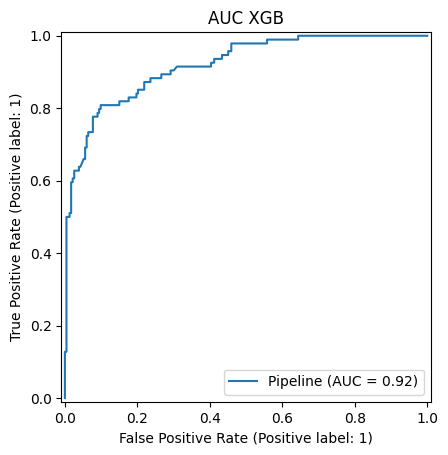

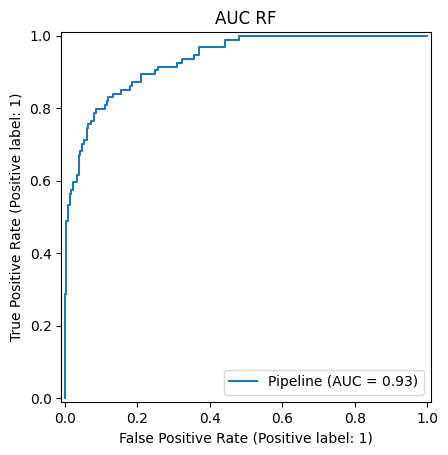

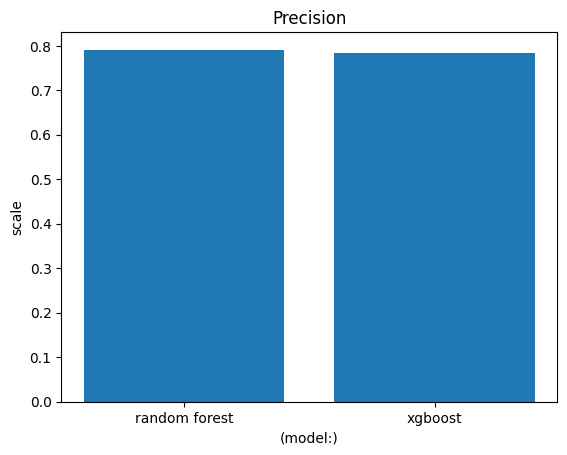

In [47]:
''' FAZER PLOT DE RESULTADOS
bACC
F1,... várias métricas(só ACC é proibido) 

para treino extra pontos para alterar pesos em vez de nº de exemplos
'''
RocCurveDisplay.from_estimator(best_xgb_model, X_test, y_test)
plt.title("AUC XGB")
plt.show()
RocCurveDisplay.from_estimator(best_rf_model, X_test, y_test)
plt.title("AUC RF")
plt.show()
#pricision XGBOOST e F1 score
rf_precission = precision_score(y_test, best_rf_model.predict(X_test))
xgb_precission = precision_score(y_test, best_xgb_model.predict(X_test))


plt.bar(["random forest", "xgboost"], [rf_precission, xgb_precission])
plt.xlabel("(model:)")
plt.ylabel("scale")
plt.title("Precision")
plt.show()

